# Bird Image Classification Project

## Imports and Data Loading

In [1]:
pip install evaluate

In [44]:
pip install datasets

In [45]:
# Imports
from datasets import load_dataset
import evaluate
from glob import glob
import imagesize
import math
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import create_optimizer, DefaultDataCollator, TFViTForImageClassification as ViTForImageClassification, ViTImageProcessor
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define path to data directory
data_dir = os.path.join('drive', 'MyDrive', 'ConcordiaBootcamp', 'Data', 'birds')

In [47]:
# Load dataset
dataset = load_dataset(path=data_dir)

Resolving data files:   0%|          | 0/3208 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

## EDA

In [ ]:
# Get one image

In [5]:
# Get subfolders
subfolders = [d.name for d in Path(data_dir).iterdir() if d.is_dir()]
subfolders

['images to predict', 'test', 'train', 'valid']

In [6]:
# Define subdirectories
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')
pred_dir = os.path.join(data_dir, 'images to predict')

In [7]:
# Get total number of images
complete_list = list(Path(data_dir).glob('*/*/*.jpg'))
nb_images = len(complete_list)
nb_images

3408

In [8]:
# Get size of train set
train_img_paths = list(Path(train_dir).glob('*/*.jpg'))
train_size = len(train_img_paths)
train_size

3208

In [9]:
# Get size of validation set
val_img_paths = list(Path(val_dir).glob('*/*.jpg'))
val_size = len(val_img_paths)
val_size

100

In [10]:
# Get size of test set
test_img_paths = list(Path(test_dir).glob('*/*.jpg'))
test_size = len(test_img_paths)
test_size

100

In [11]:
# Get number of images to predict
pred_img_paths = list(Path(pred_dir).glob('*.jpg'))
pred_size = len(pred_img_paths)
pred_size

6

In [12]:
# Get categories
categories = [d.name for d in Path(train_dir).iterdir() if d.is_dir()]
categories

['AFRICAN EMERALD CUCKOO',
 'AMERICAN COOT',
 'AFRICAN PYGMY GOOSE',
 'ABBOTTS BABBLER',
 'ALBERTS TOWHEE',
 'AMERICAN KESTREL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN GOLDFINCH',
 'AMERICAN AVOCET',
 'AMERICAN FLAMINGO',
 'AMERICAN BITTERN',
 'ABYSSINIAN GROUND HORNBILL',
 'ABBOTTS BOOBY',
 'AFRICAN FIREFINCH',
 'ALEXANDRINE PARAKEET',
 'ALBATROSS']

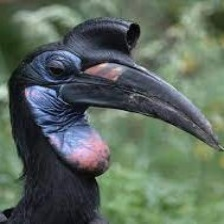

In [13]:
# Load one image at random
random.seed(42)
img_path = random.choice(complete_list)
image = Image.open(img_path)
display(image)

In [14]:
# Get average size of image
# Due to performance issues with Image.open, select 25 images at random
random.seed(42)
sample_size = 25
random_img_paths = random.sample(complete_list, k=sample_size)

sum_widths = 0
sum_heights = 0

for img_path in random_img_paths:
  img = Image.open(img_path)
  width, height = img.size
  sum_widths += width
  sum_heights += height

avg_width = sum_widths / sample_size
avg_height = sum_heights / sample_size

(avg_width, avg_height)

(224.0, 224.0)

## Data Preprocessing

In [15]:
# Reduce size of images
width = 128
height = 128

In [16]:
# Apply data augmentation to training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20)

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

Found 3208 images belonging to 20 classes.


In [17]:
# Apply data augmentation to validation set
val_datagen = ImageDataGenerator(rescale=1./255)

val_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=(width, height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

Found 100 images belonging to 20 classes.


In [18]:
# Define test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(width, height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

Found 100 images belonging to 20 classes.


In [19]:
# Create a batch of examples
data_collator = DefaultDataCollator(return_tensors="tf")

## Data Modeling

### Load pre-trained model

In [20]:
# Initialize the image processor and model
checkpoint = 'google/vit-base-patch16-224'
image_processor = ViTImageProcessor.from_pretrained(checkpoint)
model = ViTForImageClassification.from_pretrained(checkpoint)

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [21]:
pip install huggingface_hub[hf_xet]

ALPINE CHOUGH


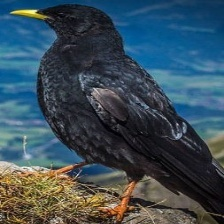

ABBOTTS BABBLER


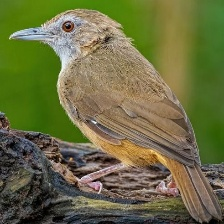

AFRICAN EMERALD CUCKOO


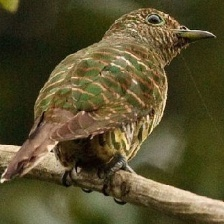

ALEXANDRINE PARAKEET


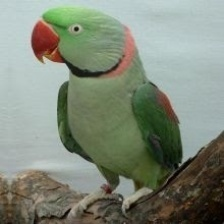

AMERICAN AVOCET


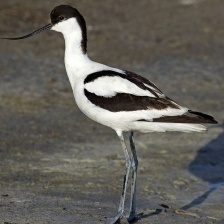

In [22]:
# Get some images from the validation set
random.seed(42)
random_img_paths = random.sample(val_img_paths, k=5)

images = []
for img_path in random_img_paths:
  img = Image.open(img_path)
  images.append(img)
  cat_name = os.path.basename(os.path.dirname(img_path))
  print(cat_name)
  display(img)

In [24]:
# Make a prediction
inputs = image_processor(images=images, return_tensors="tf")
outputs = model(**inputs)
logits = outputs.logits
logits

<tf.Tensor: shape=(5, 1000), dtype=float32, numpy=
array([[ 1.0096945 ,  0.9599745 ,  0.44593456, ...,  1.3816378 ,
         1.5982239 ,  1.0712306 ],
       [ 0.91957814,  0.10758054, -0.76344347, ..., -0.23515143,
         0.76325965, -0.24161641],
       [ 0.74029773,  0.25771236, -0.19492006, ..., -0.26592347,
         0.6203842 , -0.46814254],
       [ 0.9815354 , -0.35578385, -0.9559857 , ..., -0.5663898 ,
         1.069541  , -0.5588278 ],
       [-0.23074241, -0.26788726, -0.5444682 , ..., -0.28814885,
         0.08900231,  0.15710057]], dtype=float32)>

In [25]:
for logit in logits:
  predicted_class_idx = logit.numpy().argmax(-1).item()
  print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: black grouse
Predicted class: bulbul
Predicted class: jacamar
Predicted class: macaw
Predicted class: dowitcher


### Fine-tuning

In [26]:
# Load accurary to evaluate model
accuracy = evaluate.load("accuracy")

In [27]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [28]:
# Create mapping for categories
categories = sorted(categories)
label2id, id2label = dict(), dict()

for i, category in enumerate(categories):
    label2id[category] = str(i)
    id2label[str(i)] = category

In [29]:
label2id

{'ABBOTTS BABBLER': '0',
 'ABBOTTS BOOBY': '1',
 'ABYSSINIAN GROUND HORNBILL': '2',
 'AFRICAN CROWNED CRANE': '3',
 'AFRICAN EMERALD CUCKOO': '4',
 'AFRICAN FIREFINCH': '5',
 'AFRICAN OYSTER CATCHER': '6',
 'AFRICAN PIED HORNBILL': '7',
 'AFRICAN PYGMY GOOSE': '8',
 'ALBATROSS': '9',
 'ALBERTS TOWHEE': '10',
 'ALEXANDRINE PARAKEET': '11',
 'ALPINE CHOUGH': '12',
 'ALTAMIRA YELLOWTHROAT': '13',
 'AMERICAN AVOCET': '14',
 'AMERICAN BITTERN': '15',
 'AMERICAN COOT': '16',
 'AMERICAN FLAMINGO': '17',
 'AMERICAN GOLDFINCH': '18',
 'AMERICAN KESTREL': '19'}

In [30]:
id2label

{'0': 'ABBOTTS BABBLER',
 '1': 'ABBOTTS BOOBY',
 '2': 'ABYSSINIAN GROUND HORNBILL',
 '3': 'AFRICAN CROWNED CRANE',
 '4': 'AFRICAN EMERALD CUCKOO',
 '5': 'AFRICAN FIREFINCH',
 '6': 'AFRICAN OYSTER CATCHER',
 '7': 'AFRICAN PIED HORNBILL',
 '8': 'AFRICAN PYGMY GOOSE',
 '9': 'ALBATROSS',
 '10': 'ALBERTS TOWHEE',
 '11': 'ALEXANDRINE PARAKEET',
 '12': 'ALPINE CHOUGH',
 '13': 'ALTAMIRA YELLOWTHROAT',
 '14': 'AMERICAN AVOCET',
 '15': 'AMERICAN BITTERN',
 '16': 'AMERICAN COOT',
 '17': 'AMERICAN FLAMINGO',
 '18': 'AMERICAN GOLDFINCH',
 '19': 'AMERICAN KESTREL'}

In [31]:
# Define optimizer
batch_size = 16
num_epochs = 100
num_train_steps = 3208 * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [33]:
# Load model with label mappings
model = ViTForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
Some weights of TFViTForImageClassification were not initialized from the model checkpoint are newly initialize

In [34]:
# Configure the model for training
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

In [37]:
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [39]:
# Define callbacks from transformers
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=val_set, batch_size=batch_size)

push_to_hub_callback = PushToHubCallback(
    output_dir="bird_classifier",
    tokenizer=image_processor,
    save_strategy="no",
)

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [ ]:
callbacks = [early_stop, metric_callback, push_to_hub_callback]

### Final Model

## Make predictions

## End